In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

"""
GAN: 
 - generator model maps points in the latent space to points in image space
 - discriminator model classifies real images from the training set from fake images output from the generator network

latent space is the encoded lower dimensional representation of observed data

training:
1. train the discriminator: 
    sample batch of random points in the latent space
    turn the points into fake images via generator model
    get a batch of real images and combine them with the generated images
    train the discriminator to classify generated vs real images
    
2. train the generator
    sampel random points in the latent space
    turn the points into fake images using the generator
    get a batch of real images and combine them with generated images
    train the generator to fool the discriminator and classify the fake images as real
"""

# discriminator to classify fake vs real
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

d_optimizer = keras.optimizers.Adam(learning_rate=0.0003) # optimiser for discriminator
g_optimizer = keras.optimizers.Adam(learning_rate=0.0004) # optimiser for generator

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True) # loss function

# training loop
def train_step(real_images):
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim)) # Sample random points in the latent space
    generated_images = generator(random_latent_vectors)  # Decode them to fake images
    combined_images = tf.concat([generated_images, real_images], axis=0) # Combine them with real images

    # Assemble labels discriminating real from fake images
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((real_images.shape[0], 1))], axis=0
    )
    
    labels += 0.05 * tf.random.uniform(labels.shape) # Add random noise to the labels

    # Train the discriminator
    with tf.GradientTape() as tape:
        predictions = discriminator(combined_images)
        d_loss = loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim)) # Sample random points in the latent space
    misleading_labels = tf.zeros((batch_size, 1)) # Assemble labels that say "all real images"

    # Train the generator (note *not* update the weights of the discriminator)!
    with tf.GradientTape() as tape:
        predictions = discriminator(generator(random_latent_vectors))
        g_loss = loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
    return d_loss, g_loss, generated_images

# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)



Start epoch 0
discriminator loss at step 0: 0.46
adversarial loss at step 0: 1.10


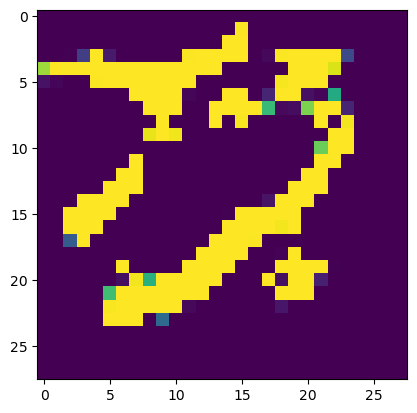

discriminator loss at step 200: 0.28
adversarial loss at step 200: 1.98


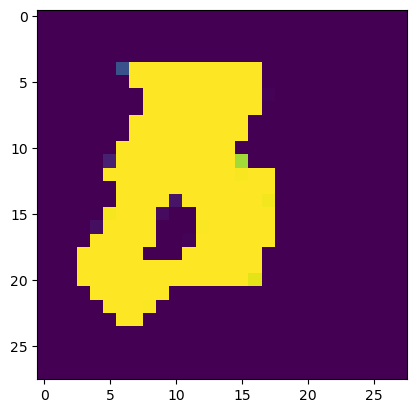

discriminator loss at step 400: 0.35
adversarial loss at step 400: 1.64


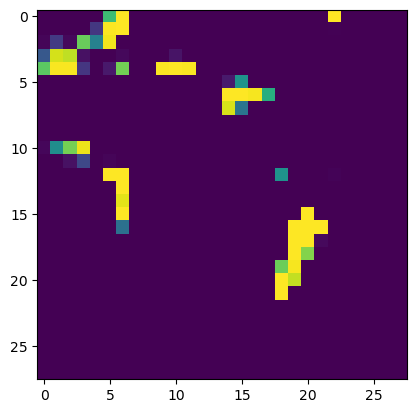

discriminator loss at step 600: 0.25
adversarial loss at step 600: 1.96


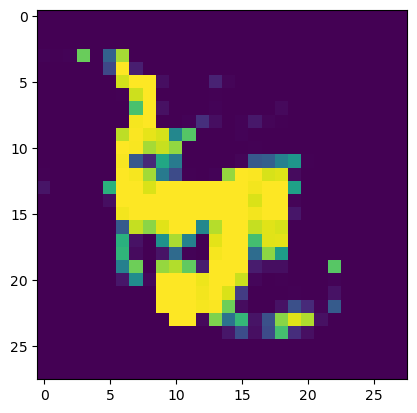

discriminator loss at step 800: 0.71
adversarial loss at step 800: 0.76


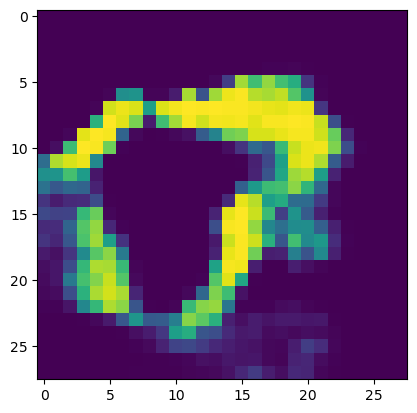

discriminator loss at step 1000: 0.65
adversarial loss at step 1000: 0.93


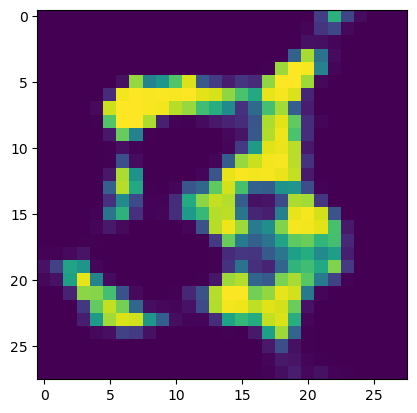

In [24]:
epochs = 1
save_dir = "./"

for epoch in range(epochs):
    print("\nStart epoch", epoch)

    for step, real_images in enumerate(dataset):
        # Train the discriminator & generator on one batch of real images.
        d_loss, g_loss, generated_images = train_step(real_images)

        # Logging.
        if step % 200 == 0:
            print("discriminator loss at step %d: %.2f" % (step, d_loss))
            print("adversarial loss at step %d: %.2f" % (step, g_loss))
            
            plt.imshow(generated_images[0] * 255.0, interpolation='nearest')
            plt.show()